In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             classification_report, roc_curve, auc, 
                             precision_recall_curve, log_loss, brier_score_loss,
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.calibration import calibration_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

### CARGA DE DATOS

In [3]:
ruta_train = os.path.join("..","..","..", "data", "P1","train.parquet")
train = pd.read_parquet(ruta_train) 
train = train.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN','ROUND'])

ruta_test = os.path.join("..","..","..", "data", "P1","test.parquet")
test = pd.read_parquet(ruta_test) 
test = test.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN','ROUND'])

In [4]:
X_train = train.drop(columns=["WINNER"])
y_train = train["WINNER"]

X_test = test.drop(columns=["WINNER"])
y_test = test["WINNER"]

### BASELINE PARA P1

Gana el que haya dado más golpes

In [5]:
y_pred = X_test["SIG_STR_DIFF"] < 0
accuracy_score(y_test,y_pred)

0.7085798816568047

### CARGA DE MODELOS

In [6]:
# Crear el modelo con los mejores hiperparámetros encontrados
mejor_arbol = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    max_features=None,
    min_samples_leaf=3,
    min_samples_split=13,
    random_state=42
)

# Entrenar el modelo
mejor_arbol.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=13,
                       random_state=42)

In [7]:
# Crear el modelo con los mejores hiperparámetros encontrados
mejor_xgboost = XGBClassifier(
    alpha=0,
    colsample_bytree=0.7,
    gamma=0,
    reg_lambda=1.0,
    learning_rate=0.3,
    max_depth=3,
    min_child_weight=2,
    n_estimators=200,
    scale_pos_weight=1,
    subsample=0.8,
    random_state=42
)

# Entrenar el modelo
mejor_xgboost.fit(X_train, y_train)

XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [8]:
ruta_train_x = os.path.join("..","..","..", "data", "P1","train_x.parquet")
x_train2 = pd.read_parquet(ruta_train_x) 
ruta_test_x = os.path.join("..","..","..", "data", "P1","test_x.parquet")
x_test2 = pd.read_parquet(ruta_test_x) 

ruta_train_y = os.path.join("..","..","..", "data", "P1","train_y.parquet")
y_train2 = pd.read_parquet(ruta_train_y) 
ruta_test_y = os.path.join("..","..","..", "data", "P1","test_y.parquet")
y_test2 = pd.read_parquet(ruta_test_y) 

# Crear el modelo con los mejores hiperparámetros encontrados (actualizados)
mejor_logistic = LogisticRegression(
    C=91.87110438153772,
    class_weight={0: 0.879041248606466, 1: 1.1595588235294119},
    fit_intercept=False,
    penalty='l2',
    solver='lbfgs',
    random_state=42
)

# Entrenar el modelo
mejor_logistic.fit(x_train2, y_train2)

c:\Users\araca\Documents\GitHub\c2425-R4\.venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\araca\Documents\GitHub\c2425-R4\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=91.87110438153772,
                   class_weight={0: 0.879041248606466, 1: 1.1595588235294119},
                   fit_intercept=False, random_state=42)

In [9]:
# Definir el diccionario de modelos
modelos = {
    'Árbol de Decisión': mejor_arbol,
    'XGBoost': mejor_xgboost,
    'Regresión Logística': mejor_logistic
}

### EVALUACION Y COMPARACION DE MODELOS

**Comparacion de la metrica elegida**

En esta celda se realiza la comparación del rendimiento de los tres modelos utilizando la métrica F1. En primer lugar, se itera sobre los modelos almacenados en el diccionario modelos. Dependiendo del modelo, se selecciona el conjunto de test adecuado (para "Regresión Logística" se utiliza x_test2 y y_test2, mientras que para los otros se usa X_test y y_test).

Para cada modelo, se realizan las predicciones sobre los datos de prueba y se calcula el F1 Score, que se almacena en el diccionario f1_scores y se imprime en consola. Posteriormente, se convierte este diccionario en un DataFrame para presentar un resumen tabulado de los resultados.

Finalmente, se genera un gráfico de barras que compara visualmente el F1 Score de cada modelo, permitiendo identificar de forma clara cuál modelo presenta un mejor equilibrio entre precisión y recall.

Árbol de Decisión F1 Score: 0.80
XGBoost F1 Score: 0.94
Regresión Logística F1 Score: 0.91

Resumen F1 Score:
                Modelo  F1 Score
0    Árbol de Decisión  0.801166
1              XGBoost  0.944742
2  Regresión Logística  0.907193


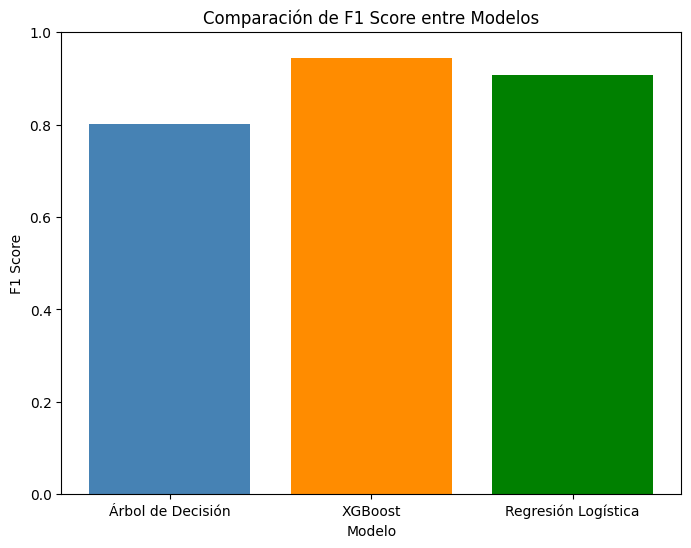

In [10]:
# Diccionario para almacenar el F1 score de cada modelo
f1_scores = {}

# Evaluar el F1 score para cada modelo
for nombre, modelo in modelos.items():
    if nombre == "Regresión Logística":
        X_eval, y_eval = x_test2, y_test2
    else:
        X_eval, y_eval = X_test, y_test
        
    y_pred = modelo.predict(X_eval)
    score = f1_score(y_eval, y_pred)
    f1_scores[nombre] = score
    print(f"{nombre} F1 Score: {score:.2f}")

# Convertir el diccionario a DataFrame para visualizar y graficar
df_f1 = pd.DataFrame(list(f1_scores.items()), columns=["Modelo", "F1 Score"])
print("\nResumen F1 Score:")
print(df_f1)

# Gráfico de barras para comparar el F1 score entre los modelos
plt.figure(figsize=(8,6))
plt.bar(df_f1["Modelo"], df_f1["F1 Score"], color=["steelblue", "darkorange", "green"])
plt.title("Comparación de F1 Score entre Modelos")
plt.xlabel("Modelo")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.show()

El resumen indica que el modelo XGBoost presenta el mejor desempeño, alcanzando un F1 Score de aproximadamente 0.94. Esto significa que XGBoost logra un excelente equilibrio entre precisión y recall en comparación con los otros modelos. La Regresión Logística, con un F1 Score alrededor de 0.90, se ubica en un nivel intermedio, mientras que el Árbol de Decisión, con un F1 de 0.80, muestra un rendimiento más moderado. En conjunto, estos resultados sugieren que XGBoost es el modelo más robusto para el problema, al lograr la mejor combinación de exactitud y sensibilidad en la clasificación.

**Metricas complementarias**

Esta celda tiene como objetivo evaluar de forma automática y comparar las métricas complementarias de cada uno de los modelos definidos. Primero, se calcula para cada modelo (usando los conjuntos de test correspondientes) un conjunto de métricas —accuracy, precisión, recall, F1, log loss y brier score— mediante la función definida. Estos resultados se almacenan en un diccionario que luego se transforma en un DataFrame para ordenar la información y facilitar su visualización. Finalmente, se genera un gráfico de barras agrupadas que permite comparar visualmente el desempeño de cada modelo en dichas métricas, ofreciendo una visión integral de cómo se comporta cada modelo en base a diferentes criterios de evaluación. Este análisis es fundamental para determinar, de manera comparativa, cuál modelo presenta un mejor equilibrio en su rendimiento.


Métricas complementarias consolidadas:
                     accuracy  precision    recall        f1  log_loss  \
Árbol de Decisión    0.831854   0.793303  0.809187  0.801166  2.493823   
XGBoost              0.954142   0.953237  0.936396  0.944742  0.112504   
Regresión Logística  0.921105   0.893714  0.921084  0.907193  0.198184   

                     brier_score  
Árbol de Decisión       0.137950  
XGBoost                 0.033671  
Regresión Logística     0.057685  


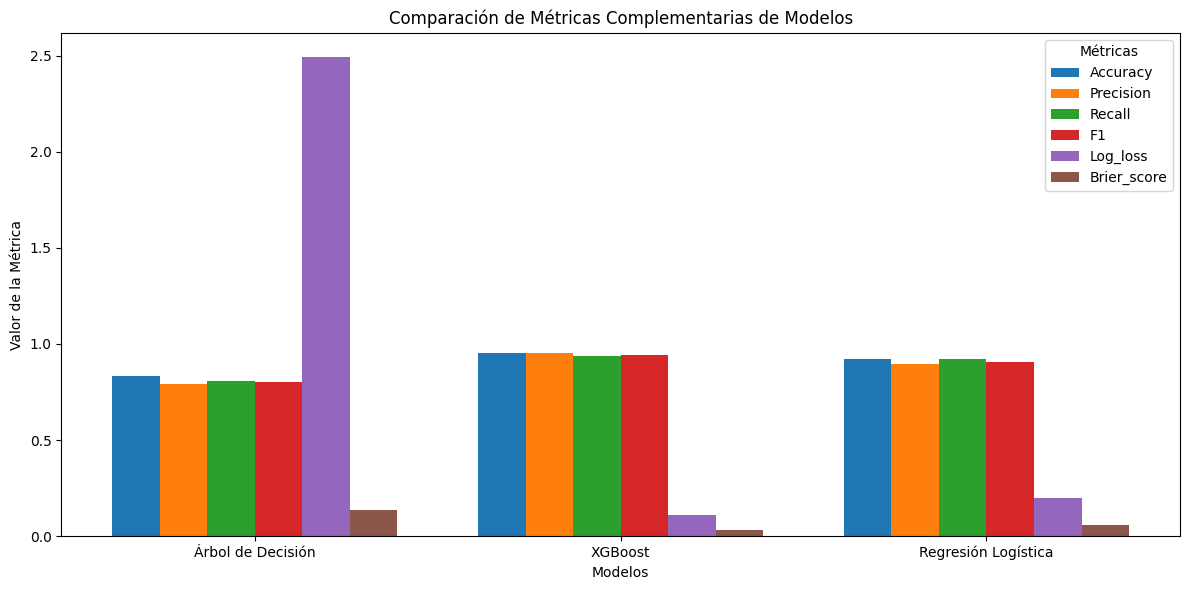

In [11]:
# Función para evaluar métricas complementarias (sin la matriz de confusión)
def evaluar_metricas_complementarias_no_cm(modelo, X, y, nombre):
    # Predicciones y probabilidades
    y_pred = modelo.predict(X)
    y_prob = modelo.predict_proba(X)[:, 1]
    
    # Cálculo de métricas
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    ll = log_loss(y, y_prob)
    brier = brier_score_loss(y, y_prob)
    
    
    # Retornamos las métricas (no se grafican las curvas en esta celda)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, 
            "log_loss": ll, "brier_score": brier}

# -------------------------------
# 1. Evaluación de métricas complementarias para cada modelo.
# Se asume que los modelos están definidos en el diccionario 'modelos' y
# que para "Regresión Logística" se usan x_test2 e y_test2, mientras que para los
# otros se utilizan X_test e y_test.
metricas_complementarias_totales = {}
for nombre, modelo in modelos.items():
    if nombre == "Regresión Logística":
        metricas = evaluar_metricas_complementarias_no_cm(modelo, x_test2, y_test2, nombre)
        
    else:
        metricas = evaluar_metricas_complementarias_no_cm(modelo, X_test, y_test, nombre)
    metricas_complementarias_totales[nombre] = metricas

# -------------------------------
# 2. Gráfico comparativo único para las métricas complementarias de TODOS los modelos.
df_metrics = pd.DataFrame(metricas_complementarias_totales).T
cols_orden = ["accuracy", "precision", "recall", "f1", "log_loss", "brier_score"]
df_metrics = df_metrics[cols_orden]
print("\nMétricas complementarias consolidadas:")
print(df_metrics)

models_list = df_metrics.index.tolist()
x_pos = np.arange(len(models_list))
width = 0.13  # ancho para cada barra

fig, ax = plt.subplots(figsize=(12, 6))
for i, metric in enumerate(cols_orden):
    ax.bar(x_pos + i * width, df_metrics[metric], width, label=metric.capitalize())

ax.set_xlabel("Modelos")
ax.set_ylabel("Valor de la Métrica")
ax.set_title("Comparación de Métricas Complementarias de Modelos")
ax.set_xticks(x_pos + width * (len(cols_orden) - 1) / 2)
ax.set_xticklabels(models_list)
ax.legend(title="Métricas")
plt.tight_layout()
plt.show()

Estos resultados muestran un desempeño claramente diferenciado entre los tres modelos. El Árbol de Decisión alcanza un accuracy de aproximadamente 83.2%, con una precisión y recall que se reflejan en un F1 Score de 0.80; sin embargo, su log loss (2.49) es relativamente alto y el brier score (0.138) indica una calibración inferior de las probabilidades. En contraste, XGBoost presenta un rendimiento sobresaliente: su accuracy es del 95.4%, con precisión y recall de 0.953 y 0.936 respectivamente, lo que se traduce en un F1 Score de 0.9447; además, su log loss (0.1125) es muy bajo y el brier score (0.0337) confirma una excelente calibración. Por último, la Regresión Logística obtiene un accuracy de aproximadamente 92.1%, con precisión de 0.8937, recall de 0.9211 y un F1 Score de 0.9072, situándose de manera intermedia en cuanto a log loss (0.1982) y brier score (0.0577) entre XGBoost y el Árbol de Decisión. En resumen, XGBoost es claramente el modelo con mejor desempeño, seguido de cerca por la Regresión Logística, mientras que el Árbol de Decisión presenta un rendimiento más moderado.

**Resultado por segmentos relevantes para el problema**

En esta celda se realiza la evaluación por segmentos de cada modelo utilizando una variable de interés para segmentar el conjunto de datos. En concreto, se utiliza la variable "REV_DIFF" para dividir los datos en cuantiles (segmentos) y, en cada uno, se calcula el accuracy del modelo. El objetivo es analizar cómo varía el desempeño del modelo en diferentes rangos de "REV_DIFF". Esta variable fue elegida porque, según los análisis previos, es la variable a la que se le otorga menos importancia en los dos mejores modelos, por lo que resulta relevante entender si existen diferencias notables en el rendimiento cuando se segmenta el conjunto de datos según sus valores. Esta evaluación ayuda a identificar posibles debilidades o comportamientos atípicos en determinadas secciones del rango de "REV_DIFF".


Evaluación por segmentos para Árbol de Decisión usando la variable 'REV_DIFF'
Árbol de Decisión - Segmento (-4.001, 0.0]: Accuracy = 0.84
Árbol de Decisión - Segmento (0.0, 3.0]: Accuracy = 0.75


C:\Users\araca\AppData\Local\Temp\ipykernel_13496\4209549509.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for seg, subdata in X_seg.groupby("segmento"):
C:\Users\araca\AppData\Local\Temp\ipykernel_13496\4209549509.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segmentos, y=scores, palette="viridis")


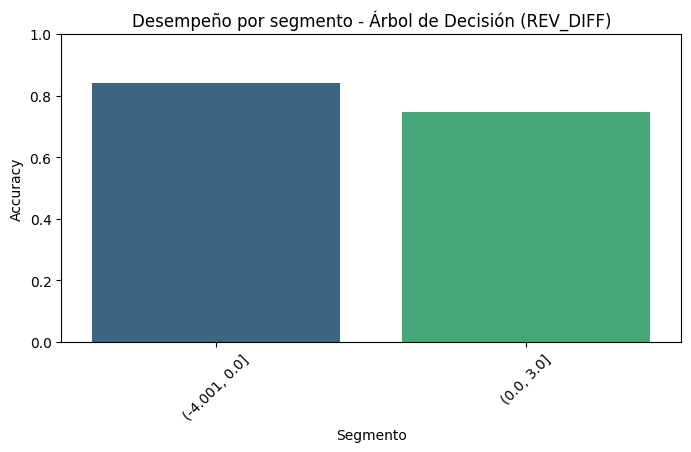


Evaluación por segmentos para XGBoost usando la variable 'REV_DIFF'
XGBoost - Segmento (-4.001, 0.0]: Accuracy = 0.96
XGBoost - Segmento (0.0, 3.0]: Accuracy = 0.92


C:\Users\araca\AppData\Local\Temp\ipykernel_13496\4209549509.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for seg, subdata in X_seg.groupby("segmento"):
C:\Users\araca\AppData\Local\Temp\ipykernel_13496\4209549509.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segmentos, y=scores, palette="viridis")


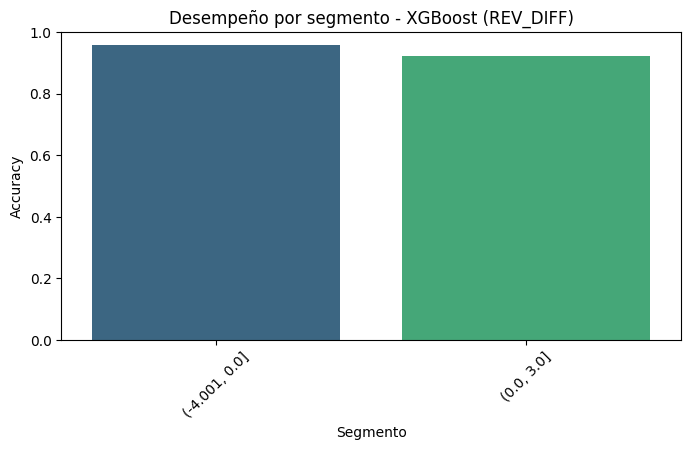


Evaluación por segmentos para Regresión Logística usando la variable 'REV_DIFF'
Regresión Logística - Segmento (-4.001, 0.0]: Accuracy = 0.92
Regresión Logística - Segmento (0.0, 3.0]: Accuracy = 0.91


C:\Users\araca\AppData\Local\Temp\ipykernel_13496\4209549509.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for seg, subdata in X_seg.groupby("segmento"):
C:\Users\araca\AppData\Local\Temp\ipykernel_13496\4209549509.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segmentos, y=scores, palette="viridis")


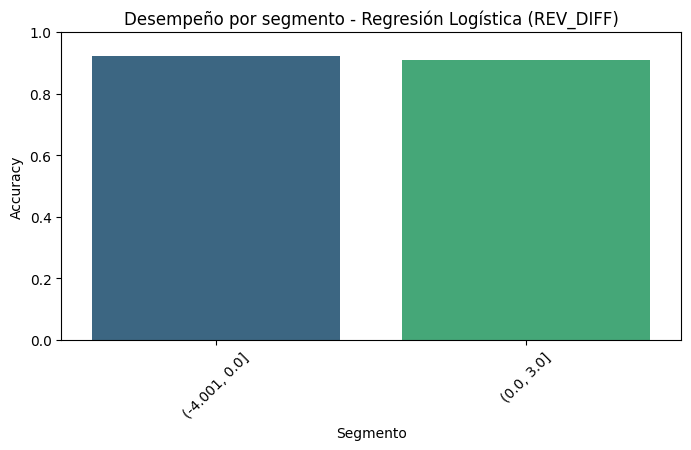

In [12]:
# Función para evaluar por segmentos
def evaluacion_por_segmentos(modelo, X, y, variable, bins=4, nombre="Modelo"):
    """
    Divide los datos en segmentos (usando los cuantiles de 'variable') y evalúa
    el desempeño (accuracy) en cada segmento.
    """
    X_seg = X.copy()
    try:
        X_seg["segmento"] = pd.qcut(X_seg[variable], bins, duplicates="drop")
    except Exception as e:
        print(f"Error en pd.qcut: {e}. Usando pd.cut en su lugar.")
        X_seg["segmento"] = pd.cut(X_seg[variable], bins)
    
    X_seg["real"] = y
    resultados = {}
    
    for seg, subdata in X_seg.groupby("segmento"):
        X_sub = subdata.drop(columns=["segmento", "real"])
        y_sub = subdata["real"]
        y_pred = modelo.predict(X_sub)
        acc = accuracy_score(y_sub, y_pred)
        resultados[str(seg)] = acc
        print(f"{nombre} - Segmento {seg}: Accuracy = {acc:.2f}")
    
    # Gráfico de desempeño por segmentos
    segmentos = list(resultados.keys())
    scores = list(resultados.values())
    plt.figure(figsize=(8, 4))
    sns.barplot(x=segmentos, y=scores, palette="viridis")
    plt.title(f"Desempeño por segmento - {nombre} ({variable})")
    plt.xlabel("Segmento")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.show()
    
    return resultados

# 3. Evaluación por segmentos con una variable de interés, por ejemplo "REV_DIFF"
variable_relevante = "REV_DIFF"
for nombre, modelo in modelos.items():
    print(f"\nEvaluación por segmentos para {nombre} usando la variable '{variable_relevante}'")
    if nombre == "Regresión Logística":
        if variable_relevante in x_test2.columns:
            evaluacion_por_segmentos(modelo, x_test2, y_test2, variable_relevante, bins=4, nombre=nombre)
        else:
            print(f"La variable {variable_relevante} no se encuentra en x_test2")
    else:
        if variable_relevante in X_test.columns:
            evaluacion_por_segmentos(modelo, X_test, y_test, variable_relevante, bins=4, nombre=nombre)
        else:
            print(f"La variable {variable_relevante} no se encuentra en X_test")

Este análisis por segmentos basado en la variable "REV_DIFF" revela diferencias significativas en el desempeño entre los modelos. XGBoost mantiene un alto accuracy (0.96 y 0.92) en ambos segmentos, mientras que Regresión Logística muestra un rendimiento constante (0.92 y 0.91). Por otro lado, el Árbol de Decisión experimenta una notable caída de 0.84 a 0.75, lo que sugiere limitaciones en ciertos rangos de "REV_DIFF". En conjunto, estos resultados indican que XGBoost es el modelo más robusto según este criterio.

**Influencia de las variables de entrada**

Esta celda se encarga de visualizar la importancia de las variables de entrada en cada uno de los modelos. El objetivo es identificar, mediante gráficos de barras, cuáles son las 10 variables más relevantes según cada modelo. Para modelos basados en árboles se utiliza el atributo "feature_importances_" y para modelos lineales se usan los coeficientes ("coef_"). Además, para Regresión Logística se utiliza X_train tal como está, mientras que en los otros modelos se elimina la columna "ROUND" si existe, pues puede no ser relevante. Esto permite entender el impacto de cada variable en la toma de decisiones de cada modelo.


Mostrando la importancia de las variables:


C:\Users\araca\AppData\Local\Temp\ipykernel_13496\1850568443.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=df_imp.head(10), palette="rocket")


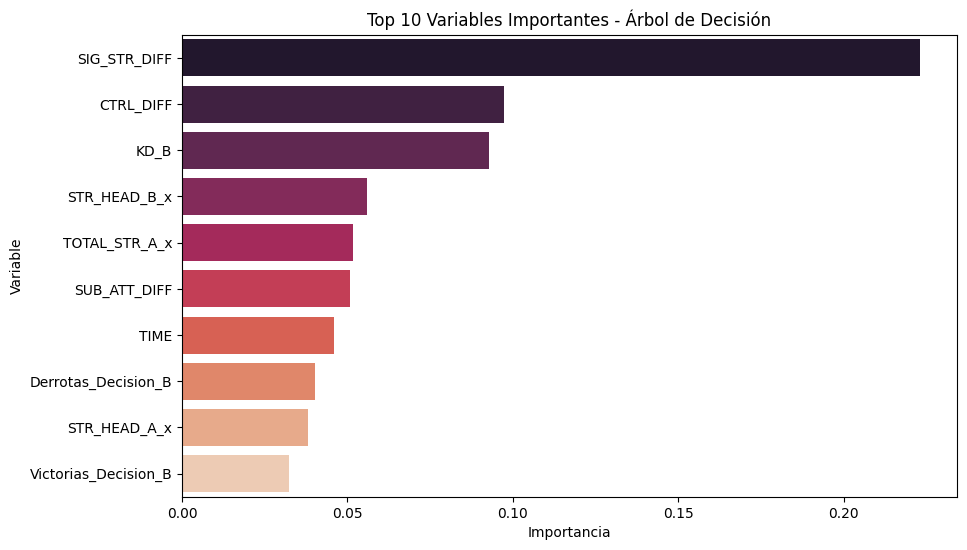

C:\Users\araca\AppData\Local\Temp\ipykernel_13496\1850568443.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=df_imp.head(10), palette="rocket")


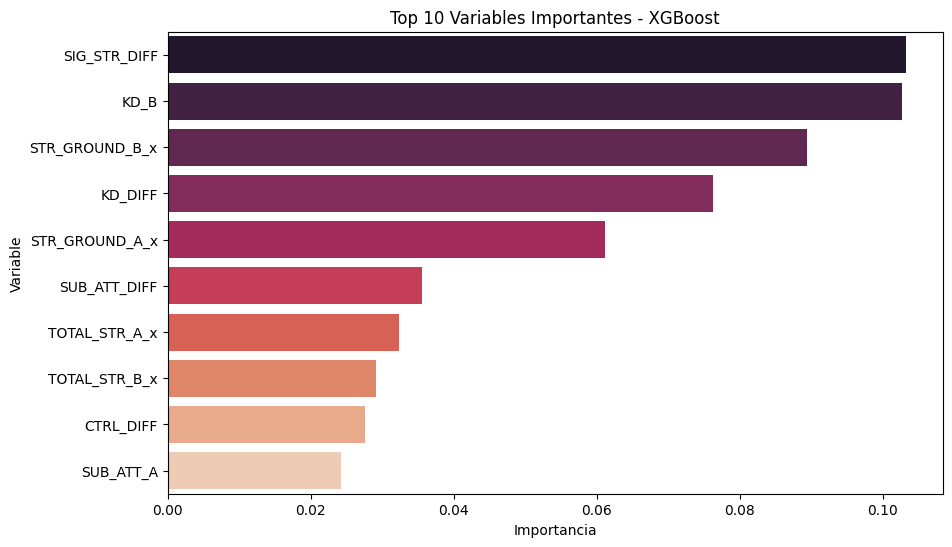

C:\Users\araca\AppData\Local\Temp\ipykernel_13496\1850568443.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=df_imp.head(10), palette="rocket")


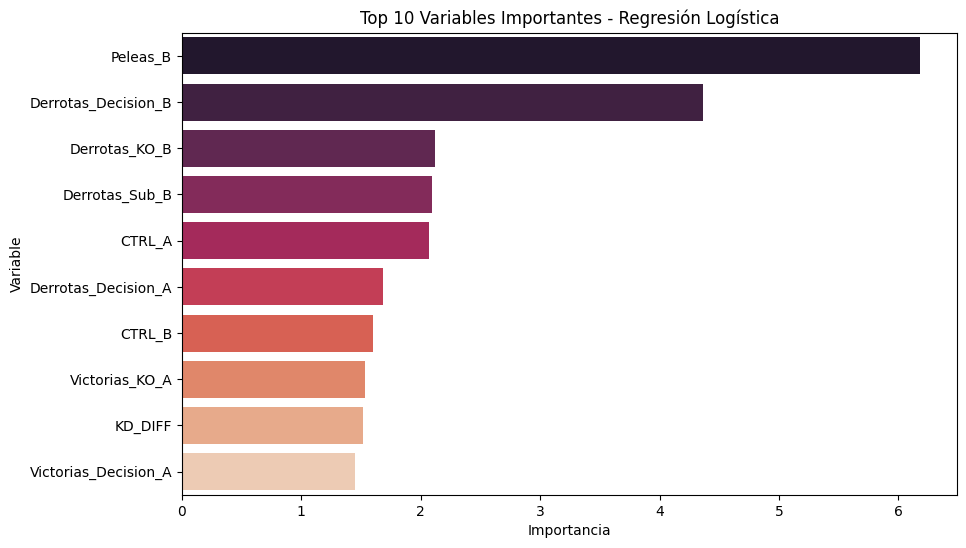

In [13]:
# Función para graficar la importancia de variables
def plot_feature_importance(modelo, X_train, nombre):
    """
    Visualiza las 10 variables con mayor importancia.
    Se usa 'feature_importances_' para modelos basados en árboles o 'coef_' para regresión.
    """
    if hasattr(modelo, 'feature_importances_'):
        features = modelo.feature_names_in_ if hasattr(modelo, "feature_names_in_") else X_train.columns
        imp = modelo.feature_importances_
        df_imp = pd.DataFrame({"feature": features, "importance": imp}).sort_values("importance", ascending=False)
    elif hasattr(modelo, 'coef_'):
        features = modelo.feature_names_in_ if hasattr(modelo, "feature_names_in_") else X_train.columns
        coef = np.abs(modelo.coef_[0])
        df_imp = pd.DataFrame({"feature": features, "importance": coef}).sort_values("importance", ascending=False)
    else:
        print(f"No se pudo extraer la importancia para {nombre}")
        return
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x="importance", y="feature", data=df_imp.head(10), palette="rocket")
    plt.title(f"Top 10 Variables Importantes - {nombre}")
    plt.xlabel("Importancia")
    plt.ylabel("Variable")
    plt.show()


# 4. Análisis de la influencia de las variables de entrada
print("\nMostrando la importancia de las variables:")
for nombre, modelo in modelos.items():
    # Para Regresión Logística se usa X_train directamente,
    # en otros modelos se elimina la columna "ROUND" si existe.
    if nombre == "Regresión Logística":
        plot_feature_importance(modelo, X_train, nombre)
    else:
        X_temp = X_train.drop(columns=["ROUND"], errors='ignore')
        plot_feature_importance(modelo, X_temp, nombre)

Observando los gráficos de importancias de las variables, se evidencia que los modelos asignan importancia a distintas variables. Por ejemplo, el Árbol de Decisión destaca especialmente la variable "SIG_STR_DIFF", mientras que a las demás no les otorga tanto peso. En cambio, XGBoost también enfatiza "SIG_STR_DIFF", pero equilibra su relevancia asignándole, además, la misma importancia a "KD_B" y otorgando gran peso a otras variables como "KD_DIFF" y "STR_GROUND" de ambos equipos. Por otro lado, la Regresión Logística se centra en las peleas del peleador 
B, en las derrotas por decisión del peleador B y en las derrotas por KO de ese peleador. Estos hallazgos indican que cada modelo se fija en aspectos diferentes del conjunto de variables, lo que resalta la necesidad de considerar múltiples enfoques para obtener una visión completa del problema.

### CONCLUSION

Después de realizar una extensa comparación entre los modelos evaluados, se puede concluir lo siguiente: aunque la Regresión Logística y XGBoost presentan un comportamiento muy similar en muchos aspectos – tanto en términos de métricas complementarias como en la estabilidad de su rendimiento en diferentes segmentos de los datos – XGBoost se destaca como el mejor modelo debido a su rendimiento superior y su mayor robustez frente a las variaciones en el conjunto de datos.

Por otro lado, el Árbol de Decisión se queda significativamente atrás en comparación con los otros dos modelos. A pesar de sus resultados inferiores, su utilidad ha residido en el proceso de selección de variables, permitiéndonos identificar cuáles son las más relevantes para clasificar correctamente nuestros datos.

En definitiva, si bien la Regresión Logística mantiene un desempeño aceptable, los resultados globales favorecen a XGBoost como la opción óptima para la implementación final en el producto, ya que consigue un mejor equilibrio entre precisión, recall y otras métricas de interés, además de ofrecer una mayor estabilidad en distintas condiciones.